# CLASSIFICATION

In [129]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
import os

from sklearn.metrics import accuracy_score, confusion_matrix

In [47]:
def seed_everything(seed=42):
    """"Seed everything.
    """   
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [48]:
seed_everything()

In [10]:
train_set = pd.read_csv("data/train_set.txt",sep = ' ')
test_set = pd.read_csv("data/test_set.txt",sep = ' ')

In [11]:
X_train = pd.DataFrame(train_set).copy()
del X_train['rain']
del X_train['rain_class']
del X_train['rain_log']

X_test = pd.DataFrame(test_set).copy()
del X_test['rain']
del X_test['rain_class']
del X_test['rain_log']

In [23]:
train_set['rain_class'] = train_set['rain_class'].astype("category")
test_set['rain_class'] = test_set['rain_class'].astype("category")

In [25]:
Y_train = train_set['rain']
Y_test = test_set['rain']

In [26]:
Y_train_class = train_set['rain_class']
Y_test_class = test_set['rain_class']


In [101]:
X_train.head()

,ff,t,td,hu,dd,precip_log,ws_arome,p3031_arome,u10_arome,v10_arome,...,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
1,-0.086213,1.164777,0.910535,-0.798235,0.520054,-0.820399,-0.036595,0.529785,0.801953,0.400758,...,0,0,0,1,0,0,0,0,0,0
2,-0.215296,-1.471529,-1.661333,-0.454718,0.695888,0.078895,-0.257664,1.323143,0.556898,-0.888709,...,1,0,0,0,0,0,0,0,0,0
4,-1.468680,0.129100,-0.187510,-1.056853,0.129012,-0.820399,-1.317523,-0.827820,-0.605044,-0.693706,...,0,0,1,0,0,0,0,0,0,0
5,1.028401,-1.238485,-1.421240,-0.491033,1.022205,0.269433,0.464623,1.063498,1.186435,-0.717044,...,0,0,0,0,0,0,0,0,0,0
6,-1.465538,-1.273800,-1.288810,0.075769,-0.850480,-0.612447,-1.277939,-0.588190,-0.432199,0.107395,...,0,0,0,0,0,0,0,0,0,1


## 1. K nearest neighbors

The completeness parameter `k` is optimised on a predefined grid by minimising the estimated error by cross-validation; scikit-learn offers many cross-validation options. 

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
# Optimisation of k
param_grid = [{"n_neighbors": list(range(1, 20))}]
knn = GridSearchCV(KNeighborsClassifier(weights = "distance"), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
knnOpt = knn.fit(X_train, Y_train_class)  
# optimal parameter
# knnOpt.best_params_["n_neighbors"]
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (knnOpt.best_score_, knnOpt.best_params_))

Best Mean cross-validated accuracy = 0.540000, Best parameter = {'n_neighbors': 18}


The prediction accuracy in the test set

In [36]:
# Estimation of the prediction accuracy on the test sample
print("Prediction accuracy in the test sample : ", knnOpt.score(X_test, Y_test_class))


Prediction accuracy in the test sample :  0.5072463768115942


In [54]:
# Prediction of the test sample
y_hat_class = knnOpt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))

# confusion matrix
table = pd.crosstab(y_hat_class, Y_test_class)
print("Confusion matrix")
print(table)

Accuracy score = 0.5072463768115942
Confusion matrix
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          20        11       11
low_rain           12        37       23
no_rain             1        10       13


## 2. Decision tree

In [90]:
from sklearn.tree import DecisionTreeClassifier
# Optimisation of shaft depth
param_grid = [{"max_depth": range(2,10), "min_samples_split" : range(2,10), "min_samples_leaf": range(1,5) }]
tree = GridSearchCV(DecisionTreeClassifier(max_features = 'auto', min_impurity_decrease = 1e-3, random_state = 42), scoring = "accuracy", param_grid = param_grid, cv=10, n_jobs=-1, refit = True)
treeOpt = tree.fit(X_train, Y_train_class)
# Optimal parameter
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (treeOpt.best_score_, treeOpt.best_params_))

Best Mean cross-validated accuracy = 0.512727, Best parameter = {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [91]:
# Estimation of the prediction error on the test sample
treeOpt.score(X_test, Y_test_class)

0.4855072463768116

In [92]:
# Prediction of the test sample
y_hat_class = treeOpt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_hat_class))
# confusion matrix
table = pd.crosstab(y_hat_class, Y_test_class)
print(table)

Accuracy score = 0.4855072463768116
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          14         6        4
low_rain           17        39       29
no_rain             2        13       14


    The `low_rain` class seems to be difficult to predict!

## 3. Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier 
# Parameters' definitions
forest = RandomForestClassifier(n_estimators = 500, 
   criterion='gini', max_depth=None,
   min_samples_split=2, min_samples_leaf=1, 
   max_features='auto', max_leaf_nodes=None,
   bootstrap=True, oob_score=True)
# Training
rfFit = forest.fit(X_train,Y_train_class)
# Out-of-bag error on the train sample
print(1-rfFit.oob_score_)
# Out-of-bag error on the test sample
print(1-rfFit.score(X_test,Y_test_class))

0.46545454545454545
0.5072463768115942


Hyper parameters tunning by cross validation

In [99]:
param=[{"n_estimators" : range(200, 500, 100) , "max_features": range(2,5), "max_depth" : range(10, 20, 2) }]
rf = GridSearchCV(RandomForestClassifier(random_state=42, criterion="entropy"),
        param, cv = 5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train_class)
print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (rfOpt.best_score_, rfOpt.best_params_))

Best Mean cross-validated accuracy = 0.545455, Best parameter = {'max_depth': 12, 'max_features': 4, 'n_estimators': 300}


In [100]:
# Prediction of the test sample
y_pred_test = treeOpt.predict(X_test)
print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Accuracy score = 0.4855072463768116
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          14         6        4
low_rain           17        39       29
no_rain             2        13       14


### Gradient Boosting applying to Random Forest

In [107]:
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [105]:
from xgboost import XGBRFClassifier

In [114]:
# define the model
model = XGBRFClassifier(n_estimators = 500, subsample = 0.99, random_state = 42, metric = "accuracy", n_jobs = -1)

In [120]:
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X_train, Y_train_class, scoring='accuracy', cv = cv, n_jobs=-1)
# report performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.528 (0.056)


In [119]:
y_pred_test = model.predict(X_test)

print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

c:\Users\nguye\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:16:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "metric" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:16:41] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score = 0.5217391304347826
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          18        10        8
low_rain           13        36       21
no_rain             2        12       18


# Support Vector Machine

## Linear SVM

In [126]:
from sklearn.svm import LinearSVC

# Neural Network

## Multi-layer Perceptron Classifier

In [130]:
from sklearn.neural_network import MLPClassifier

#### One hidden layer neural network

Firstly, we fit an one-hidden layer neural network with ReLU activation in the hidden layer and the softmax activation for the out put layer, and the log-loss function. We use here the default configuration for the optimisation task.

In [153]:
nnet1 = MLPClassifier(hidden_layer_sizes = (3), random_state = 42, max_iter = 1500)
nnet1.fit(X_train, Y_train_class)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=3, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [154]:
nnet1.out_activation_

'softmax'

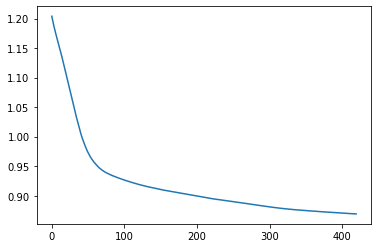

In [155]:
plt.plot(nnet1.loss_curve_)

In [156]:
y_pred_test = nnet1.predict(X_test)

print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Accuracy score = 0.5144927536231884
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          24        10        8
low_rain            8        36       28
no_rain             1        12       11


We'll use cross validation for searching the optimal number of neurones in the hidden layer

In [171]:
param_grid = [{"hidden_layer_sizes" : [(3,),(4,),(5,),(6,), (7,)], "early_stopping" : [True, False], "alpha" : [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}]

nnet1_cv = GridSearchCV(MLPClassifier(max_iter = 1500, random_state = 42), param_grid, cv = 5, n_jobs=-1, return_train_score = True)
nnet1_cv.fit(X_train, Y_train_class)

print("Best Mean cross-validated accuracy = %f, Best parameter = %s" % (nnet1_cv.best_score_, nnet1_cv.best_params_))

Best Mean cross-validated accuracy = 0.527273, Best parameter = {'alpha': 0.01, 'early_stopping': False, 'hidden_layer_sizes': (5,)}


In [173]:
nnet1Opt = nnet1_cv.best_estimator_

y_pred_test = nnet1Opt.predict(X_test)

print("Accuracy score =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Accuracy score = 0.5289855072463768
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          25        12        8
low_rain            7        33       24
no_rain             1        13       15


Text(0.5, 0, 'Iteration')

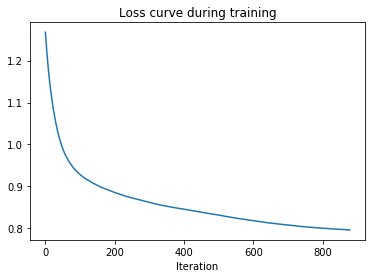

In [174]:
plt.plot(nnet1Opt.loss_curve_)
plt.title("Loss curve during training")
plt.xlabel("Iteration")

We can see that the loss function is almost reached the minimum but the prediction accuracy is still arounded $50$ percents. It means that this model does not fit well the data. We will try with more sophisticated models in the next sections

### Multilayers Neural Network

In [193]:
nnet = MLPClassifier(hidden_layer_sizes = (5, 8, 15, 20, 15, 8, 5), random_state = 42, max_iter = 1500, alpha = 0.01)
nnet.fit(X_train, Y_train_class)


MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 8, 15, 20, 15, 8, 5),
              learning_rate='constant', learning_rate_init=0.001, max_fun=15000,
              max_iter=1500, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=42,
              shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False)

Training accuracy :  0.7218181818181818


Text(0.5, 0, 'Iteration')

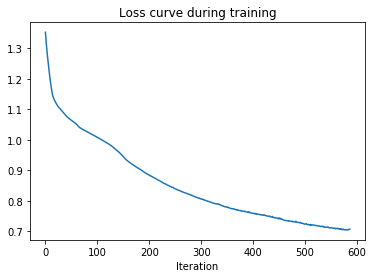

In [194]:
print("Training accuracy : ", nnet.score(X_train, Y_train_class))
plt.plot(nnet.loss_curve_)
plt.title("Loss curve during training")
plt.xlabel("Iteration")

In [195]:
y_pred_test = nnet.predict(X_test)

print("Prediction accuracy in test set =", accuracy_score(y_true = Y_test_class, y_pred = y_pred_test))
# confusion matrix
table = pd.crosstab(y_pred_test, Y_test_class)
print(table)

Prediction accuracy in test set = 0.43478260869565216
rain_class  high_rain  low_rain  no_rain
row_0                                   
high_rain          22        17       16
low_rain            8        28       21
no_rain             3        13       10


In [191]:
Y_test_class.value_counts() / Y_test_class.value_counts().sum()

low_rain     0.42029
no_rain      0.34058
high_rain    0.23913
Name: rain_class, dtype: float64

In [192]:
Y_train_class.value_counts() / Y_train_class.value_counts().sum()

low_rain     0.425455
no_rain      0.292727
high_rain    0.281818
Name: rain_class, dtype: float64